In [ ]:
# IMPORT PACKAGES

%pip install Sastrawi
%pip install nltk
%pip install wordcloud

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

import nltk
from wordcloud import WordCloud, STOPWORDS # type: ignore

In [ ]:
# DATA PREPROCESSING

data_2025 = pd.read_excel("reviews_raw_2025.xlsx")

# 1.Data Cleaning
def data_cleaning(text):
    if isinstance(text, float):
        return ""
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.strip()  # remove leading/trailing whitespace
    return text
data_2025.dropna(inplace=True)  # Removes rows with any null value
# Apply data cleaning function to 'content' column
data_2025['content_c'] = data_2025['content'].apply(data_cleaning)
data_2025 = data_2025[data_2025['content_c'] != '']
# data_2025.to_excel('reviews_2025_cleaned.xlsx', index=False)


# 2.Case Folding
data_2025['content_lowercased'] = data_2025['content_c'].str.lower()
# data_2025.to_excel('reviews_2025_lowercased.xlsx', index=False)

# 3.Stopword Removal
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory 
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover() 

def stopword_removal(text):
    return stopword.remove(text) 

data_2025['content_no_stopword'] = data_2025['content_lowercased'].apply(stopword_removal)
# data_2025.to_excel('reviews_2025_nostopword.xlsx', index=False)

# 4.Tokenization
from nltk.tokenize import word_tokenize
# Bypass SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('punkt_tab') 

data_2025['content_tokenize'] = data_2025['content_no_stopword'].apply(word_tokenize)
# data_2025.to_excel('reviews_2025_tokenize.xlsx', index=False)


# 5.Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory 
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stem_text(text):
 return stemmer.stem(text)

data_2025['content_stem'] = data_2025['content_no_stopword'].apply(stem_text)
# data_2025.to_excel('reviews_2025_stemming.xlsx', index=False)

# 6.Normalization
normalization_dict = {
 'gw': 'saya', 
 'loe': 'kamu',
 'yg': 'yang',
 'gk': 'tidak',
 'ga': 'tidak',
 'gak': 'tidak',
 'aja': 'saja',
 'btw': 'by the way',
 'klo': 'kalau',
 'nih': 'ini',
 'tdk': 'tidak',
 'dgn': 'dengan',
 'sdh': 'sudah'
} 

def normalize_text(text):
 words = text.split()
 normalized_words = [normalization_dict.get(word, word) for word in
words]
 return ' '.join(normalized_words) 

data_2025['content_normalize'] = data_2025['content_stem'].apply(normalize_text)
# data_2025.to_excel('reviews_2025_normalize.xlsx', index=False)


Sentiment Distribution:
sentiment_label
positive    1031
negative     302
Name: count, dtype: int64
Sentiment Percentages:
sentiment_label
positive    77.344336
negative    22.655664
Name: count, dtype: float64


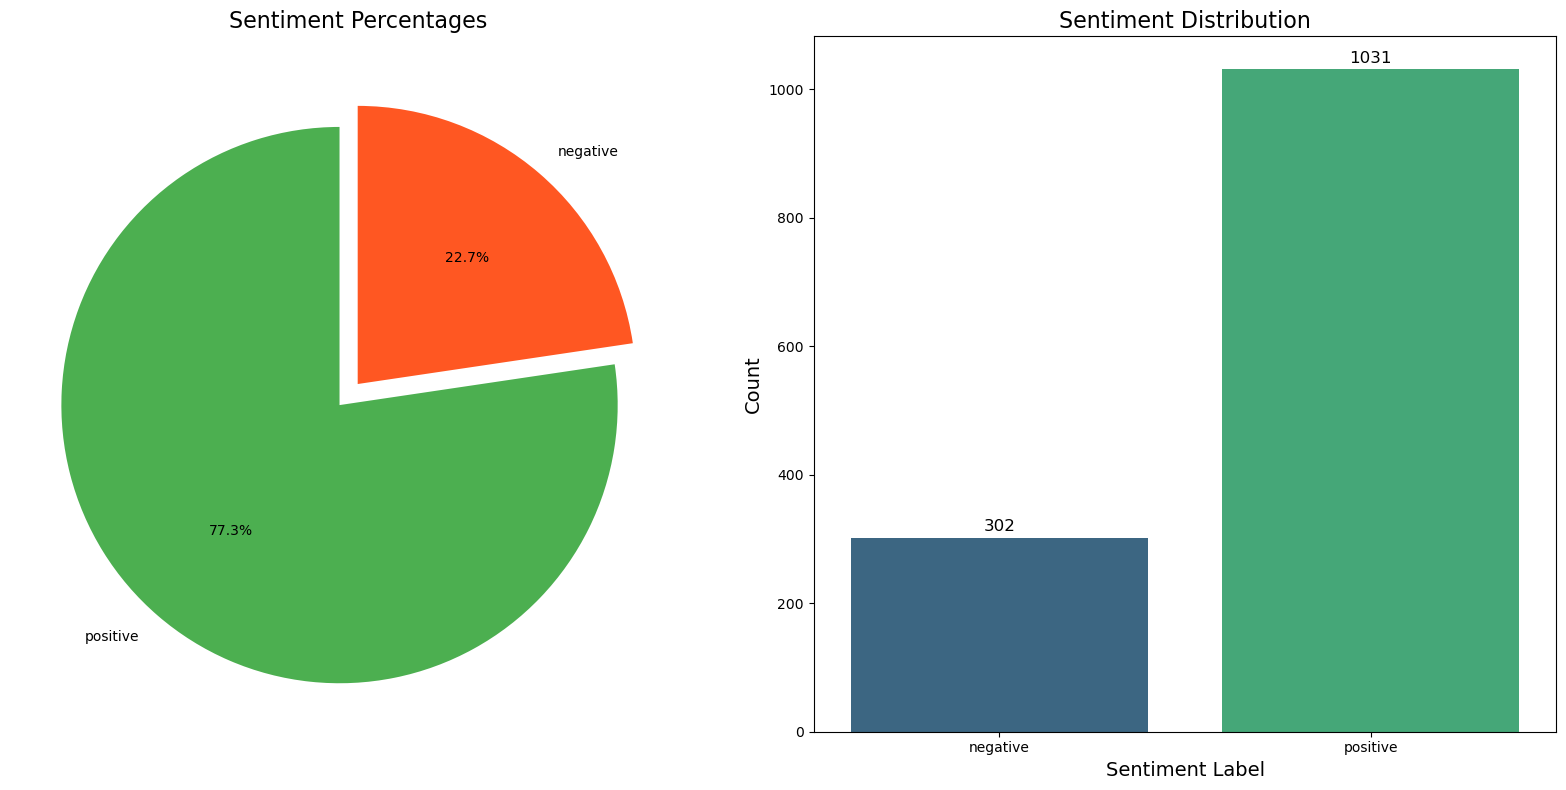

In [6]:
# DATA LABELING
df = pd.read_excel("reviews_2025_labeled.xlsx")

# Calculate sentiment percentages
sentiment_counts = df['sentiment_label'].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100

# Display sentiment percentages
print("Sentiment Distribution:")
print(sentiment_counts)
print("Sentiment Percentages:")
print(sentiment_percentages)


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pie Chart
axes[0].pie(
    sentiment_percentages, 
    labels=sentiment_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#4CAF50', '#FF5722'],
    explode=(0.1, 0)
)
axes[0].set_title('Sentiment Percentages', fontsize=16)

# Bar Plot
sns.countplot(data=df, x='sentiment_label', palette='viridis', ax=axes[1])
axes[1].set_title('Sentiment Distribution', fontsize=16)
axes[1].set_xlabel('Sentiment Label', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)

# Add counts on top of each bar
for p in axes[1].patches:
    axes[1].annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='baseline',
        fontsize=12,
        color='black',
        xytext=(0, 5),
        textcoords='offset points'
    )
plt.tight_layout()
plt.show()

Accuracy for each fold:
Fold 1: 0.81
Fold 2: 0.85
Fold 3: 0.86
Fold 4: 0.89
Fold 5: 0.86
Fold 6: 0.86
Fold 7: 0.81
Fold 8: 0.87
Fold 9: 0.84
Fold 10: 0.84
Cross-Validation Accuracy Scores: [0.81343284 0.85074627 0.85820896 0.89473684 0.86466165 0.86466165
 0.81203008 0.87218045 0.84210526 0.84210526]
Mean Accuracy: 0.85
Classification Metrics for Each Fold:
              precision    recall  f1-score   support

    negative       0.69      0.35      0.47        31
    positive       0.83      0.95      0.89       103

    accuracy                           0.81       134
   macro avg       0.76      0.65      0.68       134
weighted avg       0.80      0.81      0.79       134

              precision    recall  f1-score   support

    negative       0.79      0.48      0.60        31
    positive       0.86      0.96      0.91       103

    accuracy                           0.85       134
   macro avg       0.83      0.72      0.75       134
weighted avg       0.84      0.85      0.

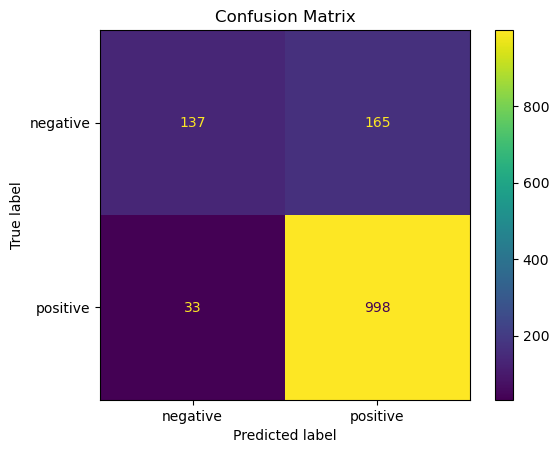

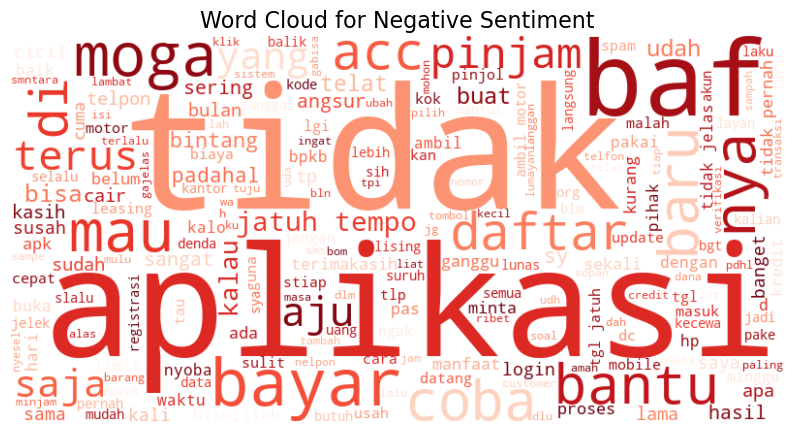

(-0.5, 799.5, 399.5, -0.5)

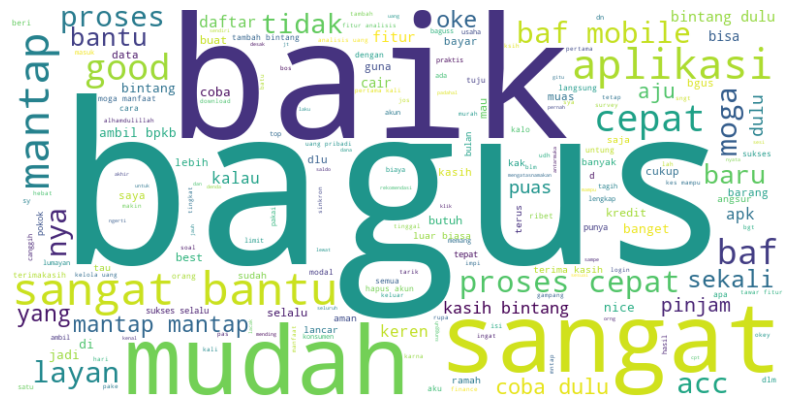

In [7]:
# CountVectorizer, without SMOTE, Naive Bayes

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("reviews_2025_labeled.xlsx")

# Separate features and target variable
X = df['content_normalize'].fillna("") 
y = df['sentiment_label']

# Define the pipeline
pipeline = ImbPipeline([
    ('vectorizer', CountVectorizer()),  # Step 1: Vectorize the text data
    ('classifier', MultinomialNB())    # Step 2: Train the Naive Bayes classifier
])

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # 80 : 20

# Perform cross-validation
scoring = make_scorer(accuracy_score)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)

# Display the accuracy for each fold
print("Accuracy for each fold:")
for i, score in enumerate(scores, start=1):
    print(f"Fold {i}: {score:.2f}")


# Display the cross-validation results
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.2f}")

# Perform cross-validation and get predictions for each fold
y_pred = cross_val_predict(pipeline, X, y, cv=cv)

# Display classification metrics for each fold
print("Classification Metrics for Each Fold:")
for train_index, test_index in cv.split(X, y):
    y_test = y.iloc[test_index]
    y_fold_pred = y_pred[test_index]
    print(classification_report(y_test, y_fold_pred, target_names=['negative', 'positive']))

# Display the overall classification report
print("Overall Classification Report:")
print(classification_report(y, y_pred, target_names=['negative', 'positive']))

# Create confusion matrix using overall predictions
cm = confusion_matrix(y, y_pred, labels=['negative', 'positive'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

negative_reviews = ' '.join(df[df['sentiment_label'] == 'negative']['content_normalize'].fillna(""))
positive_reviews = ' '.join(df[df['sentiment_label'] == 'positive']['content_normalize'].fillna(""))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_reviews)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment', fontsize=16)
plt.show()

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

Accuracy for each fold:
Fold 1: 0.78
Fold 2: 0.79
Fold 3: 0.81
Fold 4: 0.84
Fold 5: 0.81
Fold 6: 0.77
Fold 7: 0.85
Fold 8: 0.90
Fold 9: 0.78
Fold 10: 0.78
Cross-Validation Accuracy Scores: [0.7761194  0.79104478 0.81343284 0.84210526 0.81203008 0.76691729
 0.84962406 0.90225564 0.78195489 0.78195489]
Mean Accuracy: 0.81
Classification Metrics for Each Fold:
              precision    recall  f1-score   support

    negative       0.51      0.71      0.59        31
    positive       0.90      0.80      0.85       103

    accuracy                           0.78       134
   macro avg       0.71      0.75      0.72       134
weighted avg       0.81      0.78      0.79       134

              precision    recall  f1-score   support

    negative       0.53      0.87      0.66        31
    positive       0.95      0.77      0.85       103

    accuracy                           0.79       134
   macro avg       0.74      0.82      0.75       134
weighted avg       0.85      0.79      0.

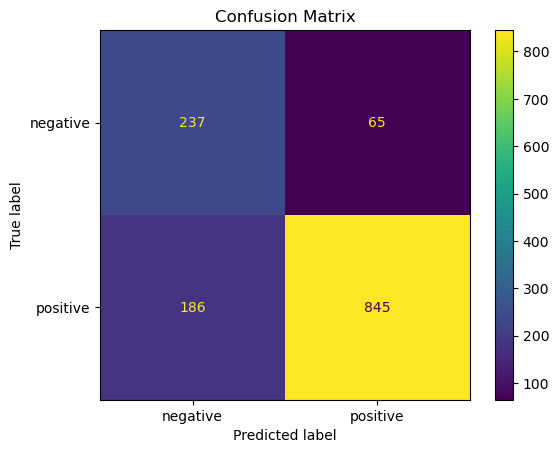

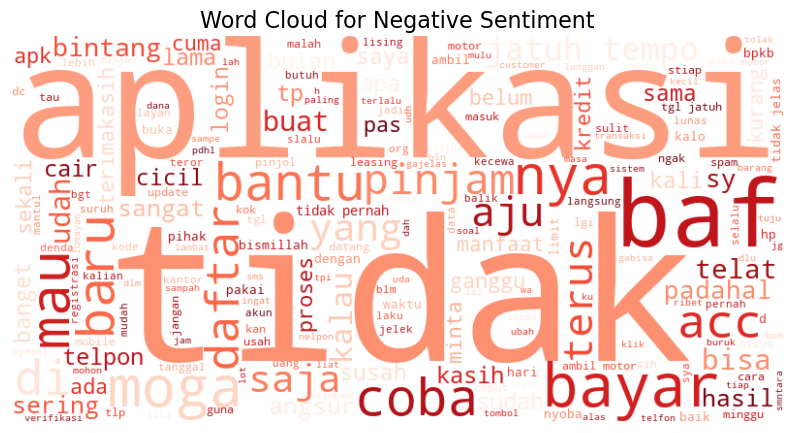

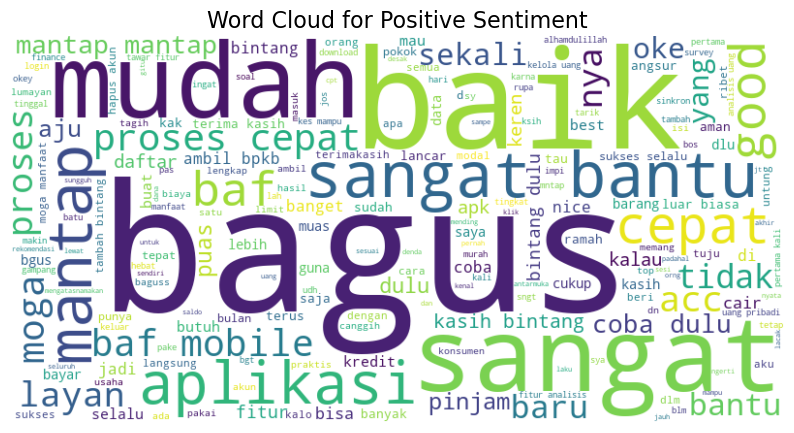

In [8]:
# CountVectorizer, with SMOTE, Naive Bayes

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("reviews_2025_labeled.xlsx")

# Separate features and target variable
X = df['content_normalize'].fillna("") 
y = df['sentiment_label']

# Define the pipeline
pipeline = ImbPipeline([
    ('vectorizer', CountVectorizer()),  # Step 1: Vectorize the text data
    ('smote', SMOTE(random_state=42)),  # Step 2: Apply SMOTE
    ('classifier', MultinomialNB())    # Step 3: Train the Naive Bayes classifier
])

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # 80 : 20

# Perform cross-validation
scoring = make_scorer(accuracy_score)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)

# Display the accuracy for each fold
print("Accuracy for each fold:")
for i, score in enumerate(scores, start=1):
    print(f"Fold {i}: {score:.2f}")


# Display the cross-validation results
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.2f}")

# Perform cross-validation and get predictions for each fold
y_pred = cross_val_predict(pipeline, X, y, cv=cv)

# Display classification metrics for each fold
print("Classification Metrics for Each Fold:")
for train_index, test_index in cv.split(X, y):
    y_test = y.iloc[test_index]
    y_fold_pred = y_pred[test_index]
    print(classification_report(y_test, y_fold_pred, target_names=['negative', 'positive']))

# Display the overall classification report
print("Overall Classification Report:")
print(classification_report(y, y_pred, target_names=['negative', 'positive']))

# Create confusion matrix using overall predictions
cm = confusion_matrix(y, y_pred, labels=['negative', 'positive'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

negative_reviews = ' '.join(df[df['sentiment_label'] == 'negative']['content_normalize'].fillna(""))
positive_reviews = ' '.join(df[df['sentiment_label'] == 'positive']['content_normalize'].fillna(""))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_reviews)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment', fontsize=16)
plt.show()

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment', fontsize=16)
plt.show()